# Driver Drownsiness Detection 

## import Denpendencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import tensorflow as tf
from tensorflow.keras import layers, models
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import json
import infer

/var/folders/47/rh12lnbx26b9bbkz9gvkfsmr0000gn/T/ipykernel_23512/1075810200.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


# Set Constant

In [2]:
with open('my_dir/constants.json', 'r') as file:
    data = json.load(file)

BATCH_SIZE = data["BATCH_SIZE"]
IMAGE_SIZE = data["IMAGE_SIZE"]
CHANNELS = data["CHANNELS"]

# Load Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'train',#change your directory here
    seed = 123,
    shuffle = True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 9420 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Closed', 'Open', 'no_yawn', 'yawn']

# Visaulize some image

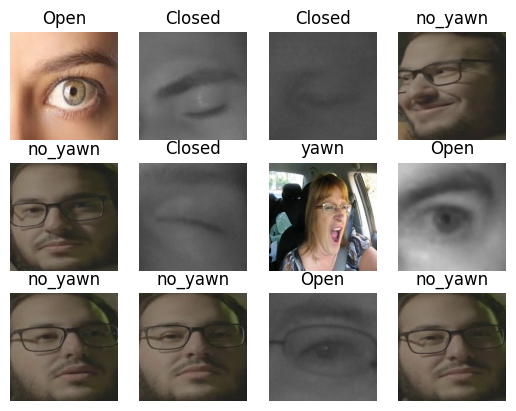

In [5]:
for image_batch, labels_name in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_name[i]])
        plt.axis('off')
        
plt.show()

# Split Dataset

In [ ]:
train_ds, val_ds, test_ds = infer.get_split_data(dataset,train_split=0.7, test_splt=0.2, val_split=0.1, shuffle=True, shuffle_size=100)



# Cache, Shuffle and Prefitch data

In [7]:
#caches elements in memory during the first iteration through the dataset 
#prefetches elements from the dataset to improve performance
#shuffles the elements of the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing And Normalization

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

# Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# Applying Data Augmentation to Train Dataset

In [10]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [102]:
# Hyperparameters to search through
hypermodel = infer.MyHyperModel(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=4)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hparam_tuning')


# Early Stopping setup
early_stopping = EarlyStopping(
    monitor='val_accuracy', #val_accuracy
    patience=10,
    restore_best_weights=True)

# Start tuning
tuner.search(train_ds, batch_size=BATCH_SIZE, epochs=2, validation_data=val_ds)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=30, validation_data=val_ds,callbacks = [early_stopping])


Reloading Tuner from my_dir/hparam_tuning/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.0010463766655229093.

Epoch 1/30
329/329 [==============================] - 347s 1s/step - loss: 0.7711 - accuracy: 0.7009 - val_loss: 0.5538 - val_accuracy: 0.7043
Epoch 2/30
329/329 [==============================] - 324s 984ms/step - loss: 0.5527 - accuracy: 0.7763 - val_loss: 0.5570 - val_accuracy: 0.7372
Epoch 3/30
329/329 [==============================] - 335s 1s/step - loss: 0.5545 - accuracy: 0.7726 - val_loss: 0.6162 - val_accuracy: 0.7149
Epoch 4/30
329/329 [==============================] - 332s 1s/step - loss: 0.5183 - accuracy: 0.7866 - val_loss: 0.3694 - val_accuracy: 0.8553
Epoch 5/30
329/329 [==============================] - 320s 972ms/step - loss: 0.4820 - accuracy: 0.8103 - val_loss: 0.4637 - val_accuracy: 0.8691
Epoch 6/30
329/329 [==================

In [ ]:
#calculate average training scores
average_train_loss = np.mean(history.history['loss'])
average_train_accuracy = np.mean(history.history['accuracy'])


# Calculate average validation scores
average_val_loss = np.mean(history.history['val_loss'])
average_val_accuracy = np.mean(history.history['val_accuracy'])

print(f'Average Validation Loss: {average_train_loss:.4f}')
print(f'Average Validation Accuracy: {average_train_accuracy:.4f}')
print(f'Average Validation Loss: {average_val_loss:.4f}')
print(f'Average Validation Accuracy: {average_val_accuracy:.4f}')


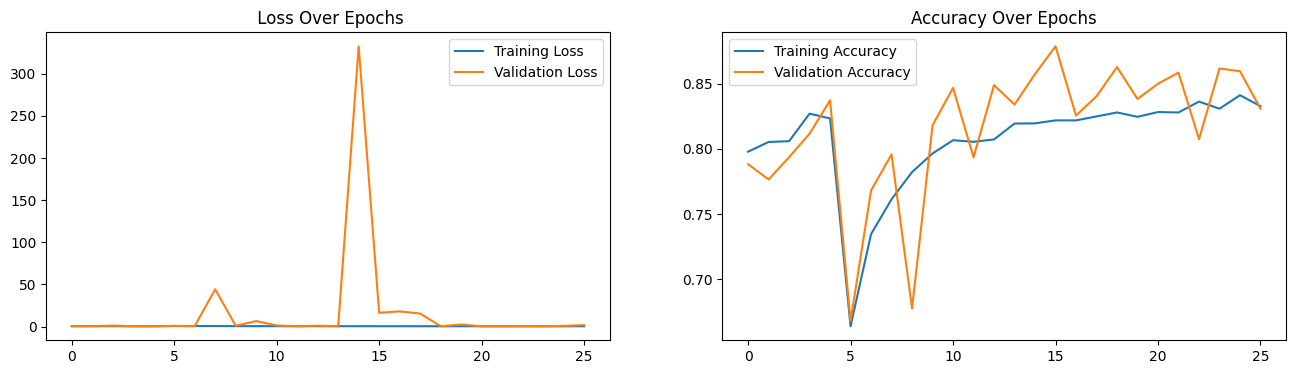

In [33]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f' Loss Over Epochs')
plt.legend()
# plt.savefig(f'batch size= 10, earlystopping, base model, Training and validation loss epochs {ep}.png')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy Over Epochs')
plt.legend()
# plt.savefig(f'{name_model} results.png')
plt.show()


In [112]:
name_model = '3hyperparam_model_earlystopping_loss_mse'
model_save_path = f'my_dir/{name_model}.h5'  # H5 is a common format for Keras models
model.save(model_save_path)


/opt/homebrew/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# System To Make Predict

In [12]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidance = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidance

1/1 [==============================] - 0s 41ms/step


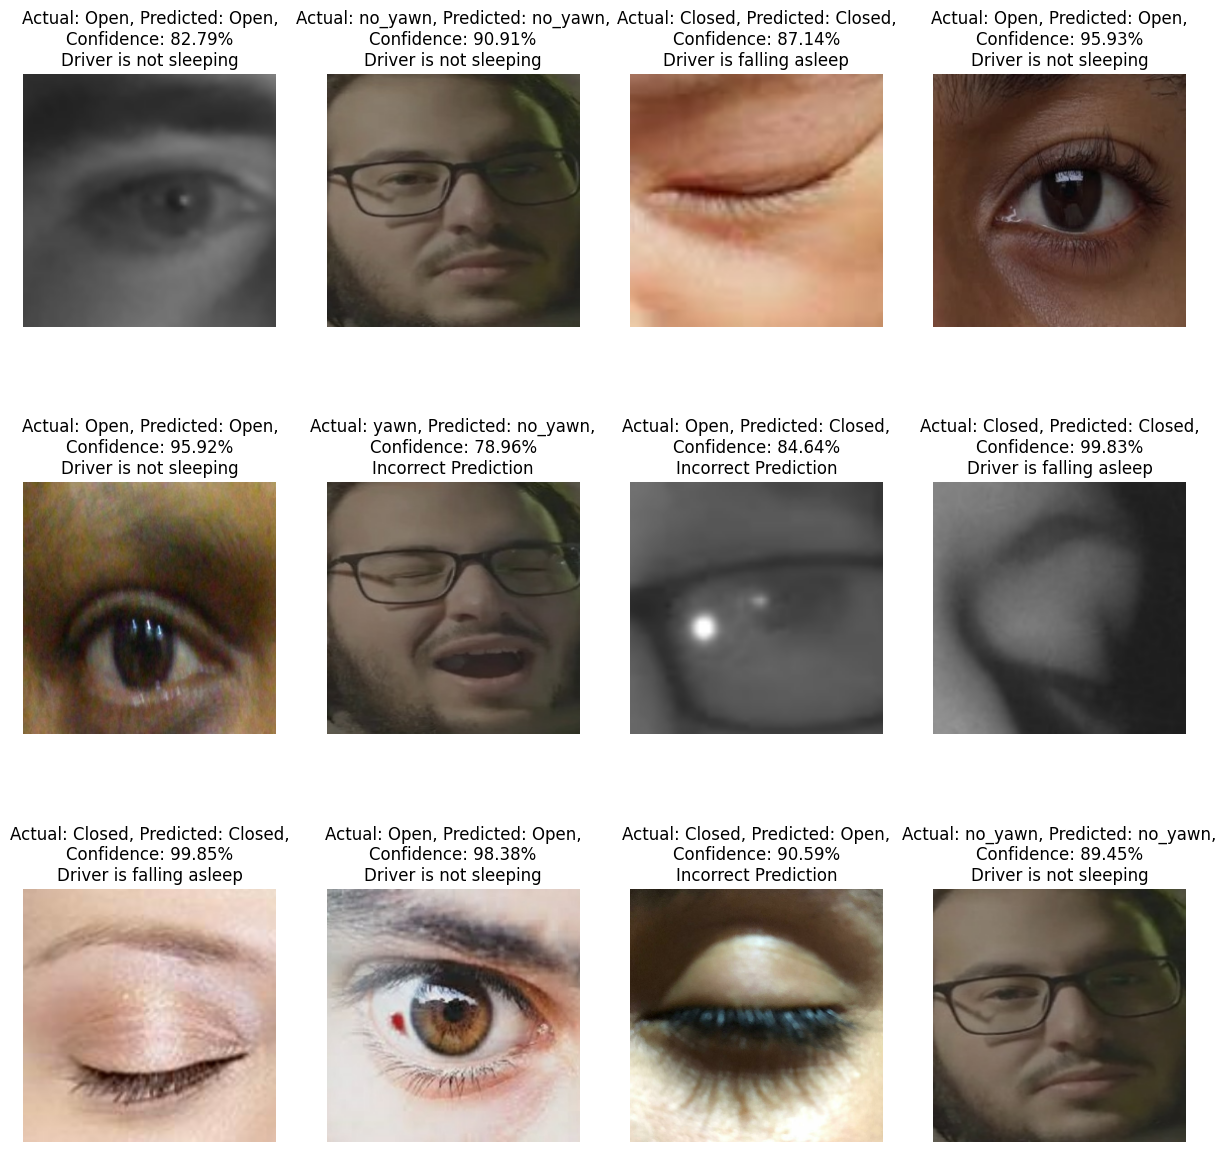

In [18]:
# Assuming 'load_model', 'test_ds', 'class_names' and 'predict' are already defined
loaded_model = load_model('my_dir/2hyperparam_model_earlystopping.h5')

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(loaded_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        # Determine the title based on prediction accuracy and specific condition
        if predicted_class == actual_class:
            if actual_class == "yawn" or actual_class == "Closed":
                message = "Driver is falling asleep"
            elif actual_class == "no_yawn" or actual_class == "Open":
                message = "Driver is not sleeping"
            else:
                message = "Condition unclear"  # For any other classes if they exist
            plt.title(f"Actual: {actual_class}, Predicted: {predicted_class},\nConfidence: {confidence:.2f}%\n{message}")
        else:
            plt.title(f"Actual: {actual_class}, Predicted: {predicted_class},\nConfidence: {confidence:.2f}%\nIncorrect Prediction")

        plt.axis('off')
        plt.savefig("outputs/output_final.png")
plt.show()


In [ ]:
for layer in filter(lambda x: 'conv' in x.name, loaded_model.layers):
    weights_shape, bias_shape = map(lambda x: x.shape, layer.get_weights())

with open('outputs/weights_model.txt', 'w') as file: 
    for item in layer.get_weights():
        file.write(f"{item}")

print(layer.get_weights())